<a href="https://colab.research.google.com/github/mgonzalez8/ProyectoUNICEF/blob/master/IntentosSuicidios_ProyectoUNICEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Proyecto UNICEF - Detección Temprana Intentos de SUicidio</h1>


**Integrantes**

Juan Manuel Hurtado
Manuel González González
Maria Elena Cordoba
Lilian Murillo Cordoba
Otros Integrantes(Preguntar Nombre Completo)

**Cómo detectar de manera temprana los intentos de suicidios en jovenes entre 12 y 17 años en IES en la ciudad de Buenaventura?**

Con los datos que tenemos procedemos a realizar el modelo que detecta de manera temprana los intentos de suicidios en los jovenes de la ciudad de Buenaventura

In [3]:
pip install geopandas

In [4]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [5]:
import pandas              as pd # The gold standard of Python data analysis, to create and manipulate tables of data
import numpy               as np # The Python module for processing arrays which/Pandas is based on
import matplotlib.pyplot   as plt # The gold standard of Python data visualization, but can be complex to use
import seaborn             as sns; sns.set() # A package to make Matplotlib visualizations more aesthetic
import branca
import geopandas


from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

import folium # package for making maps, please make sure to use a version older than 1.0.0.
from wordcloud import WordCloud # A package that will allow us to make a wordcloud
from scipy.stats import ttest_ind # A module for Python machine learning--we'll stick to T-Tests here
from IPython.display import display
from folium.plugins import TimeSliderChoropleth
# from time_slider_choropleth import TimeSliderChoropleth
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)

Exploración de patrones asociados a variables individuales de interés
Vamos a leer y ver nuestro conjunto de datos. Este conjunto de datos, Contiene los intentos de suicidios en Buenaventura, por edad, estrato, comuna, genero, composición familiar, nivel de escolaridad, antecedentes mentales, antecedentes por consumo.

Comenzamos con una exploración básica de la distribución de los distintos parámetros. Dado que este conjunto de datos se centra más en los datos categóricos, empezaremos por investigar las distintas frecuencias de cada categoría dentro de cada parámetro:

In [6]:
df = pd.read_csv('INTENTOS_DATA_PRUEBA.csv')
df.head(5)


,Id,Anio,Edad,Sexo,Estrato,Escolaridad,Comuna,Localidad,Num_Int,Intento
0,1,2021,10,M,2,6,9,2,3,1
1,2,2020,13,M,2,8,10,2,0,1
2,3,2019,15,M,4,10,3,1,1,1
3,4,2021,15,F,2,9,11,2,3,1
4,5,2021,14,F,3,12,10,2,2,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           1000 non-null   int64 
 1   Anio         1000 non-null   int64 
 2   Edad         1000 non-null   int64 
 3   Sexo         1000 non-null   object
 4   Estrato      1000 non-null   int64 
 5   Escolaridad  1000 non-null   int64 
 6   Comuna       1000 non-null   int64 
 7   Localidad    1000 non-null   int64 
 8   Num_Int      1000 non-null   int64 
 9   Intento      1000 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 78.2+ KB


In [8]:
#Estamos mirando los valores únicos
pd.unique(df["Sexo"])

array(['M', 'F'], dtype=object)

In [9]:
#Estamos mirando los valores únicos
pd.unique(df["Edad"])

array([10, 13, 15, 14, 11, 18, 17, 12, 16])

In [10]:
#Observamos la cantidad de nulos que tiene la columna
df["Edad"].isna().sum()

0

In [11]:
#Estamos mirando los valores únicos
pd.unique(df["Estrato"])

array([2, 4, 3, 1])

In [12]:
#df['estrato'] = df['estrato'].replace(np.nan, 1)

In [13]:
#Estamos mirando los valores únicos
pd.unique(df["Anio"])

array([2021, 2020, 2019, 2022, 2018])

In [14]:
#Estamos mirando los valores únicos
#pd.unique(df["bar_ver"])

In [15]:
#df['bar_ver'] = df['bar_ver'].replace(np.nan,'SIN INFORMACION')

In [16]:
#Aqui tomo las columnas que me sirven para el problema

trainE = df[["Id","Edad","Sexo","Estrato","Escolaridad","Comuna","Localidad","Num_Int","Intento"]]

#trainS = df[["EST_DESARTA"]]

##print(trainS.head(5),"\n",trainsE.head(5))

print(trainE.head(5))

   Id  Edad Sexo  Estrato  Escolaridad  Comuna  Localidad  Num_Int  Intento
0   1    10    M        2            6       9          2        3        1
1   2    13    M        2            8      10          2        0        1
2   3    15    M        4           10       3          1        1        1
3   4    15    F        2            9      11          2        3        1
4   5    14    F        3           12      10          2        2        1


In [17]:
trainE.isna().sum()

Id             0
Edad           0
Sexo           0
Estrato        0
Escolaridad    0
Comuna         0
Localidad      0
Num_Int        0
Intento        0
dtype: int64

In [18]:
#Trabajar las edades
#Realmente para facilitar encontrar patrones para la RN, es más util usar un rango de edad que una edad en un valor entero
trainE["Edad"] = pd.cut(trainE["Edad"],[0,5,10,15,20,25,30,35,40,45,50,60,70,100])

<ipython-input-18-6d0b2819d834>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainE["Edad"] = pd.cut(trainE["Edad"],[0,5,10,15,20,25,30,35,40,45,50,60,70,100])


In [19]:
trainE.loc[:,"Sexo"],categoriaSex=pd.factorize(trainE["Sexo"], sort=True)
categoriaSex

<ipython-input-19-e47a831e6cf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainE.loc[:,"Sexo"],categoriaSex=pd.factorize(trainE["Sexo"], sort=True)
<ipython-input-19-e47a831e6cf4>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  trainE.loc[:,"Sexo"],categoriaSex=pd.factorize(trainE["Sexo"], sort=True)


Index(['F', 'M'], dtype='object')

In [20]:
trainE.loc[:,"Edad"],categoriaAge=pd.factorize(trainE["Edad"], sort=True)
categoriaAge

<ipython-input-20-7f18a935ef9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainE.loc[:,"Edad"],categoriaAge=pd.factorize(trainE["Edad"], sort=True)
<ipython-input-20-7f18a935ef9b>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  trainE.loc[:,"Edad"],categoriaAge=pd.factorize(trainE["Edad"], sort=True)


CategoricalIndex([(5, 10], (10, 15], (15, 20]], categories=[(0, 5], (5, 10], (10, 15], (15, 20], ..., (45, 50], (50, 60], (60, 70], (70, 100]], ordered=True, dtype='category')

In [21]:
trainE.loc[:,"Escolaridad"],categoriaEsc=pd.factorize(trainE["Escolaridad"], sort=True)
categoriaEsc

<ipython-input-21-ac1fa3b0ea1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainE.loc[:,"Escolaridad"],categoriaEsc=pd.factorize(trainE["Escolaridad"], sort=True)


Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [22]:
trainE.loc[:,"Comuna"],categoriaCom=pd.factorize(trainE["Comuna"], sort=True)
categoriaCom

<ipython-input-22-c9656edc8ed8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainE.loc[:,"Comuna"],categoriaCom=pd.factorize(trainE["Comuna"], sort=True)


Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [23]:
trainE.loc[:,"Localidad"],categoriaLoc=pd.factorize(trainE["Localidad"], sort=True)
categoriaLoc

<ipython-input-23-d7e8fc4f7e0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainE.loc[:,"Localidad"],categoriaLoc=pd.factorize(trainE["Localidad"], sort=True)


Int64Index([1, 2], dtype='int64')

In [24]:
trainE.loc[:,"Num_Int"],categoriaNumI=pd.factorize(trainE["Num_Int"], sort=True)
categoriaNumI

<ipython-input-24-9a270710c97f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainE.loc[:,"Num_Int"],categoriaNumI=pd.factorize(trainE["Num_Int"], sort=True)


Int64Index([0, 1, 2, 3], dtype='int64')

In [25]:
trainE.head()

,Id,Edad,Sexo,Estrato,Escolaridad,Comuna,Localidad,Num_Int,Intento
0,1,0,1,2,5,8,1,3,1
1,2,1,1,2,7,9,1,0,1
2,3,1,1,4,9,2,0,1,1
3,4,1,0,2,8,10,1,3,1
4,5,1,0,3,11,9,1,2,1


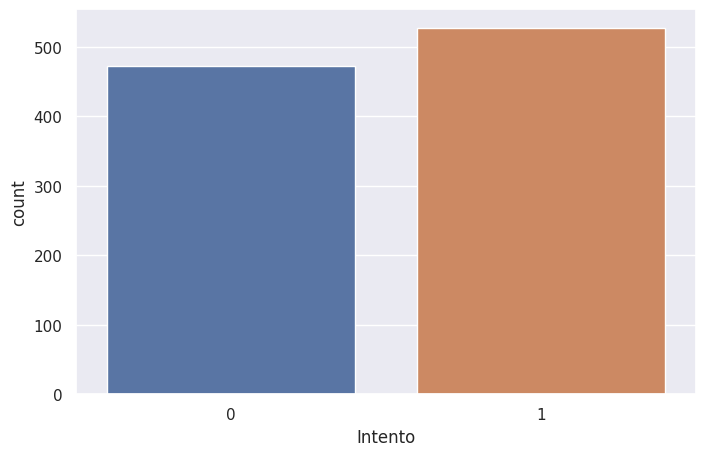

In [26]:
sns.countplot(x='Intento', data=trainE);

In [27]:
pip install -U imbalanced-learn

In [28]:
#VamosaNormalizar

x_train=trainE.iloc[:,0:8].values
y_train=trainE.iloc[:,8].values
x_train,y_train

(array([[   1,    0,    1, ...,    8,    1,    3],
        [   2,    1,    1, ...,    9,    1,    0],
        [   3,    1,    1, ...,    2,    0,    1],
        ...,
        [ 998,    1,    0, ...,    3,    0,    1],
        [ 999,    1,    0, ...,    5,    1,    3],
        [1000,    2,    1, ...,    9,    1,    0]]),
 array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1,

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.3,random_state=0)

In [30]:
x_train=pd.DataFrame(x_train).iloc[:,1:8].values

x_train2=(pd.DataFrame(x_test)).iloc[:,0].values
x_test=pd.DataFrame(x_test).iloc[:,1:8].values
Resul=x_test
Resul

array([[1, 0, 4, ..., 4, 0, 2],
       [1, 1, 1, ..., 9, 1, 1],
       [1, 0, 1, ..., 1, 0, 3],
       ...,
       [2, 0, 1, ..., 9, 1, 3],
       [2, 0, 2, ..., 8, 1, 0],
       [1, 1, 2, ..., 6, 1, 0]])

In [31]:
x_train

array([[ 2,  1,  2, ...,  7,  1,  3],
       [ 2,  1,  1, ...,  2,  0,  0],
       [ 1,  1,  2, ...,  8,  1,  2],
       ...,
       [ 1,  1,  4, ..., 10,  1,  2],
       [ 0,  0,  1, ...,  5,  1,  0],
       [ 2,  1,  3, ..., 11,  1,  2]])

In [32]:
x_test

array([[1, 0, 4, ..., 4, 0, 2],
       [1, 1, 1, ..., 9, 1, 1],
       [1, 0, 1, ..., 1, 0, 3],
       ...,
       [2, 0, 1, ..., 9, 1, 3],
       [2, 0, 2, ..., 8, 1, 0],
       [1, 1, 2, ..., 6, 1, 0]])

In [33]:
x_train2

array([ 994,  860,  299,  554,  673,  972,   28,  232,  307,  707,  497,
        559,  785,  240,  579,   56,  907,  176,   15,   78,   32,  482,
        311,  312,  884,  789,   46,  104,  761,    2,  824,  711,  615,
        791,  409,  737,  958,  367,  919,  268,  231,  997,  636,  699,
        252,  784,  820,  142,  317,  588,  332,  296,  263,  433,  863,
        583,  273,  271,  988,  320,  570,  644,  143,  203,  414,  197,
        265,  532,  253,  577,  739,  300,  741,  248,  927,  413,  390,
        797,  602,  655,  262,  457,  387,  983,  910,  694,  237,  502,
        498,  875,  453,  495,  924,  280,  639,  486,  569,  109,  368,
        645,  786,  874,   66,  903,  318,  637,  667,  790,  959,  215,
         98,  584,  467,  524,  256,  386,  546,  383,  490,  514,  781,
        905,  123,  947,   61,  845,  373,  284,  940,  609,  496,  631,
        597,  714,  754,  625,  313,    9,  530,  877,  102,  616,  521,
        250,  279,  425,  385,  396,   55,   35,  2

In [34]:
ResulTado=pd.DataFrame(x_train2)
ResulTado

,0
0,994
1,860
2,299
3,554
4,673
...,...
295,168
296,999
297,985
298,492


In [35]:
x_test

array([[1, 0, 4, ..., 4, 0, 2],
       [1, 1, 1, ..., 9, 1, 1],
       [1, 0, 1, ..., 1, 0, 3],
       ...,
       [2, 0, 1, ..., 9, 1, 3],
       [2, 0, 2, ..., 8, 1, 0],
       [1, 1, 2, ..., 6, 1, 0]])

In [36]:
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_train

array([[ 1.20279829,  1.00573071, -0.43214683, ...,  0.48428488,
         0.90192655,  1.31249984],
       [ 1.20279829,  1.00573071, -1.32978119, ..., -0.94972279,
        -1.10873773, -1.35311879],
       [-0.3948465 ,  1.00573071, -0.43214683, ...,  0.77108641,
         0.90192655,  0.4239603 ],
       ...,
       [-0.3948465 ,  1.00573071,  1.36312189, ...,  1.34468948,
         0.90192655,  0.4239603 ],
       [-1.99249128, -0.99430195, -1.32978119, ..., -0.08931819,
         0.90192655, -1.35311879],
       [ 1.20279829,  1.00573071,  0.46548753, ...,  1.63149101,
         0.90192655,  0.4239603 ]])

In [37]:
x_test=scaler.transform(x_test)
x_test

array([[-0.3948465 , -0.99430195,  1.36312189, ..., -0.37611973,
        -1.10873773,  0.4239603 ],
       [-0.3948465 ,  1.00573071, -1.32978119, ...,  1.05788794,
         0.90192655, -0.46457925],
       [-0.3948465 , -0.99430195, -1.32978119, ..., -1.23652433,
        -1.10873773,  1.31249984],
       ...,
       [ 1.20279829, -0.99430195, -1.32978119, ...,  1.05788794,
         0.90192655,  1.31249984],
       [ 1.20279829, -0.99430195, -0.43214683, ...,  0.77108641,
         0.90192655, -1.35311879],
       [-0.3948465 ,  1.00573071, -0.43214683, ...,  0.19748334,
         0.90192655, -1.35311879]])

In [38]:
#aplicamos la clasificacion por algortmos Bayesianos - naivebayes
from sklearn.naive_bayes import GaussianNB
#C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
#gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#kernel=['rbf','linear']
clasificadorNB = GaussianNB()
clasificadorNB.fit(x_train,y_train)
y_preditNB=clasificadorNB.predict(x_test)

In [39]:
y_preditNB

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [40]:
from sklearn.metrics import confusion_matrix
cmNB=confusion_matrix(y_test,y_preditNB)
cmNB

array([[ 13, 139],
       [ 22, 126]])

In [41]:
x_train2

array([ 994,  860,  299,  554,  673,  972,   28,  232,  307,  707,  497,
        559,  785,  240,  579,   56,  907,  176,   15,   78,   32,  482,
        311,  312,  884,  789,   46,  104,  761,    2,  824,  711,  615,
        791,  409,  737,  958,  367,  919,  268,  231,  997,  636,  699,
        252,  784,  820,  142,  317,  588,  332,  296,  263,  433,  863,
        583,  273,  271,  988,  320,  570,  644,  143,  203,  414,  197,
        265,  532,  253,  577,  739,  300,  741,  248,  927,  413,  390,
        797,  602,  655,  262,  457,  387,  983,  910,  694,  237,  502,
        498,  875,  453,  495,  924,  280,  639,  486,  569,  109,  368,
        645,  786,  874,   66,  903,  318,  637,  667,  790,  959,  215,
         98,  584,  467,  524,  256,  386,  546,  383,  490,  514,  781,
        905,  123,  947,   61,  845,  373,  284,  940,  609,  496,  631,
        597,  714,  754,  625,  313,    9,  530,  877,  102,  616,  521,
        250,  279,  425,  385,  396,   55,   35,  2

In [42]:
y_preditNB

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [43]:
ResulTado["Intento"]=pd.DataFrame(y_preditNB)
ResulTado

,0,Intento
0,994,1
1,860,1
2,299,1
3,554,1
4,673,1
...,...,...
295,168,1
296,999,1
297,985,1
298,492,1


In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
rocNB=roc_auc_score(y_test,y_preditNB)
rocNB

0.4684388335704125

In [45]:
from sklearn.metrics import classification_report
print (classification_report(y_test,y_preditNB))

              precision    recall  f1-score   support

           0       0.37      0.09      0.14       152
           1       0.48      0.85      0.61       148

    accuracy                           0.46       300
   macro avg       0.42      0.47      0.37       300
weighted avg       0.42      0.46      0.37       300



In [46]:
scoreNB=clasificadorNB.score(x_test,y_test)
scoreNB

0.4633333333333333

In [47]:
score=clasificadorNB.score(x_train,y_train)
score

0.5471428571428572

In [48]:
#aplicamos la clasificacio por algortmos de Regresion - Regresion Logistica
from sklearn.linear_model import LogisticRegression
#penalty in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]
clasificadorLR = LogisticRegression(solver = 'saga',penalty='l2',random_state=0)
clasificadorLR.fit(x_train,y_train)
y_preditLR=clasificadorLR.predict(x_test)

In [49]:

cmLR=confusion_matrix(y_test,y_preditLR)
cmLR

array([[ 11, 141],
       [ 16, 132]])

In [50]:
print (classification_report(y_test,y_preditLR))

              precision    recall  f1-score   support

           0       0.41      0.07      0.12       152
           1       0.48      0.89      0.63       148

    accuracy                           0.48       300
   macro avg       0.45      0.48      0.37       300
weighted avg       0.44      0.48      0.37       300



In [51]:
scoreLR=clasificadorLR.score(x_test,y_test)
scoreLR

0.4766666666666667

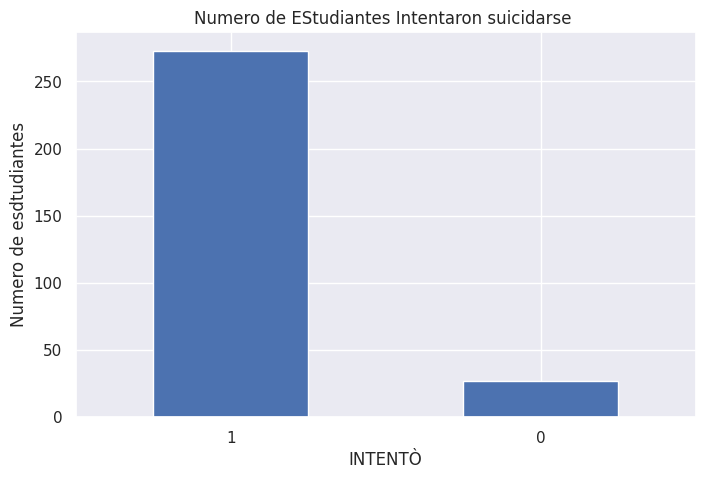

In [52]:
count_classes = pd.value_counts(y_preditLR, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Numero de EStudiantes Intentaron suicidarse ")
plt.xlabel("INTENTÒ")
plt.ylabel("Numero de esdtudiantes");

In [53]:
ResulTado["Intento"]=pd.DataFrame(y_preditLR)
ResulTado

,0,Intento
0,994,1
1,860,1
2,299,1
3,554,1
4,673,1
...,...,...
295,168,1
296,999,0
297,985,1
298,492,1


In [54]:
#aplicamos la clasificacio por algoritmos de Arbol de Decisión - Arboles de Clasificación
from sklearn.tree import DecisionTreeClassifier
clasificadorDT = DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.0)
clasificadorDT.fit(x_train,y_train)
y_preditDT=clasificadorDT.predict(x_test)

In [55]:
cmDT=confusion_matrix(y_test,y_preditDT)
cmDT

array([[77, 75],
       [79, 69]])

In [56]:
print (classification_report(y_test,y_preditDT))

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       152
           1       0.48      0.47      0.47       148

    accuracy                           0.49       300
   macro avg       0.49      0.49      0.49       300
weighted avg       0.49      0.49      0.49       300



In [57]:
scoreDT=clasificadorDT.score(x_test,y_test)
scoreDT

0.4866666666666667

In [58]:
ResulTado["Intento"]=pd.DataFrame(y_preditDT)
ResulTado

,0,Intento
0,994,0
1,860,1
2,299,0
3,554,0
4,673,0
...,...,...
295,168,1
296,999,0
297,985,1
298,492,1


In [59]:
#aplicamos la clasificacio por algoritmos Algoritmos basados en Instancia - k-Nearest Neighbor (kNN) minkowski, manhattan,euclidean
from sklearn.neighbors import KNeighborsClassifier
clasificadorKNN = KNeighborsClassifier(n_neighbors= 11, metric="euclidean",p=2)
clasificadorKNN.fit(x_train,y_train)
y_preditKNN=clasificadorKNN.predict(x_test)

In [60]:
cmKNN=confusion_matrix(y_test,y_preditKNN)
cmKNN

array([[ 46, 106],
       [ 52,  96]])

In [61]:
print (classification_report(y_test,y_preditKNN))

              precision    recall  f1-score   support

           0       0.47      0.30      0.37       152
           1       0.48      0.65      0.55       148

    accuracy                           0.47       300
   macro avg       0.47      0.48      0.46       300
weighted avg       0.47      0.47      0.46       300



In [62]:
scoreKNN=clasificadorKNN.score(x_test,y_test)
scoreKNN

0.47333333333333333

In [63]:
ResulTado["Intento"]=pd.DataFrame(y_preditKNN)
ResulTado

,0,Intento
0,994,0
1,860,1
2,299,0
3,554,1
4,673,0
...,...,...
295,168,0
296,999,1
297,985,0
298,492,1


In [64]:
#aplicamos la clasificacion algoritmos Algoritmo - SVC
from sklearn.svm import SVC
clasificadorSVC = SVC(kernel = "sigmoid", random_state = 0, gamma="auto")
clasificadorSVC.fit(x_train, y_train)
# Predicción de los resultados con el Conjunto de Testing
y_preditSVC  = clasificadorSVC.predict(x_test)

In [65]:
cmSVC=confusion_matrix(y_test,y_preditSVC)
cmSVC


array([[71, 81],
       [59, 89]])

In [66]:
print (classification_report(y_test,y_preditSVC))

              precision    recall  f1-score   support

           0       0.55      0.47      0.50       152
           1       0.52      0.60      0.56       148

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.53       300
weighted avg       0.53      0.53      0.53       300



In [67]:
scoreSVC=clasificadorSVC.score(x_test,y_test)
scoreSVC

0.5333333333333333

In [68]:
ResulTado["Intento"]=pd.DataFrame(y_preditSVC)
ResulTado

,0,Intento
0,994,1
1,860,0
2,299,0
3,554,0
4,673,1
...,...,...
295,168,0
296,999,1
297,985,1
298,492,1


In [69]:
# Ajustar el clasificador  Random Forest en el Conjunto de Entrenamiento
from sklearn.ensemble import RandomForestClassifier
clasificadorRFC = RandomForestClassifier(n_estimators = 10, max_depth=None, min_samples_split = 2, min_samples_leaf = 1, criterion = "entropy", verbose=2, random_state=42, n_jobs = -1)
clasificadorRFC.fit(x_train, y_train)
# Predicción de los resultados con el Conjunto de Testing
y_preditRFC = clasificadorRFC.predict(x_test)

building tree 1 of 10
building tree 2 of 10building tree 3 of 10
building tree 4 of 10

building tree 5 of 10
building tree 6 of 10building tree 7 of 10
building tree 8 of 10

building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [70]:
cmRFC=confusion_matrix(y_test,y_preditRFC)
print(cmRFC)

[[79 73]
 [70 78]]


In [71]:
print (classification_report(y_test,y_preditRFC))

              precision    recall  f1-score   support

           0       0.53      0.52      0.52       152
           1       0.52      0.53      0.52       148

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300



In [72]:
scoreRFC=clasificadorRFC.score(x_test,y_test)
scoreRFC

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5233333333333333

In [73]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# Use la cuadrícula aleatoria para buscar los mejores hiperparámetros
# Primero cree el modelo base para sintonizar
# Búsqueda aleatoria de parámetros, usando 3 veces la validación cruzada,
# busque en 100 combinaciones diferentes y use todos los núcleos disponibles

In [74]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Ajuste el modelo de búsqueda aleatoria
rf_random.fit (x_train, y_train)
y_preditRFCV = rf_random.predict(x_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [75]:
y_test

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [76]:
def evaluate(model, x_test, y_test):
    predictions = model.predict(x_test)
    print(predictions)
    errors = abs(predictions - y_test)
    print(errors)
    #mape = 100 * np.mean(errors / y_test)
    mape = np.mean(errors / y_test)
    print(mape)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

[0.3        0.7        0.3        0.8        0.9        0.7
 0.5        0.8        0.4        0.8        0.2        0.36666667
 0.5        0.2        0.6        0.1        0.4        0.4
 0.         0.4        0.         0.15       0.8        0.4
 0.9        0.4        0.8        0.2        0.7        0.8
 0.8        0.5        0.4        0.7        0.9        0.1
 0.6        0.4        0.8        0.7        0.66       0.3
 0.6        0.6        0.8        0.8        0.5        0.8
 0.1        0.3        0.3        0.7        0.9        0.675
 0.5        0.7        0.93333333 0.49333333 0.6        0.9
 0.8        0.2        0.6        0.6        0.8        0.7
 0.5        0.8        0.8        0.8        0.8        0.2
 0.8        0.8        0.1        0.7        0.53333333 0.8
 0.7        0.         0.5        0.2        0.3        0.1
 0.3        0.2        0.9        0.9        0.3        0.4
 0.2        0.55       0.4        0.5        0.5        0.2
 0.4        0.8        0.4     

<ipython-input-76-b5e3c8f543b0>:7: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(errors / y_test)
<ipython-input-76-b5e3c8f543b0>:7: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(errors / y_test)


In [77]:
ResulTado["Intento"]=pd.DataFrame(y_preditRFC)
ResulTado.head(23)

,0,Intento
0,994,0
1,860,1
2,299,0
3,554,1
4,673,1
5,972,1
6,28,0
7,232,1
8,307,1
9,707,1
